<a href="https://colab.research.google.com/github/straylight77/data-sci-learning/blob/master/titanic/titanic4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

data_raw = pd.read_csv('https://raw.githubusercontent.com/straylight77/data-sci-learning/master/titanic/train.csv')
data = data_raw.copy(deep=True)

data.sample(5)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
354,355,0,3,"Yousif, Mr. Wazli",male,NaN,0,0,2647,7.2250,NaN,C
476,477,0,2,"Renouf, Mr. Peter Henry",male,34.0,1,0,31027,21.0000,NaN,S
295,296,0,1,"Lewy, Mr. Ervin G",male,NaN,0,0,PC 17612,27.7208,NaN,C
670,671,1,2,"Brown, Mrs. Thomas William Solomon (Elizabeth ...",female,40.0,1,1,29750,39.0000,NaN,S
547,548,1,2,"Padro y Manent, Mr. Julian",male,NaN,0,0,SC/PARIS 2146,13.8625,NaN,C


In [2]:
####################################################################
# fill in missing data
data['Age'].fillna( data['Age'].median(), inplace=True )
data['Embarked'].fillna( data['Embarked'].mode()[0], inplace=True )
data['Fare'].fillna( data['Fare'].median(), inplace=True )

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       891 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [3]:
# feature engineering 
data['Relatives'] = data['SibSp'] + data['Parch']

data['IsAlone'] = data['Relatives'].apply(lambda x: 0 if x > 0 else 1) 

# qcut vs cut: https://stackoverflow.com/questions/30211923/what-is-the-difference-between-pandas-qcut-and-pandas-cut
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.qcut.html
data['FareBin'] = pd.qcut(data['Fare'], 4)

# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.cut.html
data['AgeBin'] = pd.cut(data['Age'].astype(int), 5)

# extract the passenger's title from their name (Mr, Miss, Dr, etc.)
data['Title'] = data['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]

# replace rare Titles (< stat_min) with 'Other'
stat_min = 10 
title_names = (data['Title'].value_counts() < stat_min)
data['Title'] = data['Title'].apply(lambda x: 'Other' if title_names.loc[x] == True else x)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 17 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       891 non-null object
Relatives      891 non-null int64
IsAlone        891 non-null int64
FareBin        891 non-null category
AgeBin         891 non-null category
Title          891 non-null object
dtypes: category(2), float64(2), int64(7), object(6)
memory usage: 106.7+ KB


In [4]:
# convert types to work with the model
from sklearn import preprocessing

label = preprocessing.LabelEncoder()
data['Sex_Code'] = label.fit_transform(data['Sex'])
data['Embarked_Code'] = label.fit_transform(data['Embarked'])
data['Title_Code'] = label.fit_transform(data['Title'])
data['AgeBin_Code'] = label.fit_transform(data['AgeBin'])
data['FareBin_Code'] = label.fit_transform(data['FareBin'])

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 22 columns):
PassengerId      891 non-null int64
Survived         891 non-null int64
Pclass           891 non-null int64
Name             891 non-null object
Sex              891 non-null object
Age              891 non-null float64
SibSp            891 non-null int64
Parch            891 non-null int64
Ticket           891 non-null object
Fare             891 non-null float64
Cabin            204 non-null object
Embarked         891 non-null object
Relatives        891 non-null int64
IsAlone          891 non-null int64
FareBin          891 non-null category
AgeBin           891 non-null category
Title            891 non-null object
Sex_Code         891 non-null int64
Embarked_Code    891 non-null int64
Title_Code       891 non-null int64
AgeBin_Code      891 non-null int64
FareBin_Code     891 non-null int64
dtypes: category(2), float64(2), int64(12), object(6)
memory usage: 141.5+ KB


In [5]:
#####################################################################
# prepare training data 
y = data.Survived

features = ['Pclass', 'Relatives', 'Sex_Code', 'Title_Code', 'AgeBin_Code', 'FareBin_Code' ]
X = data[features]

# split into validation and training data
#   train_X = data to be used to train a model (with labels in train_y)
#   val_X = data to be used to measure accuracy (compare predictions with val_y) 
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
print("training data rows: ", len(train_X))
print(" testing data rows: ", len(val_X))
print("original data rows: ", len(X))
if len(train_X) + len(val_X) == len(X):
    print("Good to go!") 

training data rows:  668
 testing data rows:  223
original data rows:  891
Good to go!


In [6]:
# create a model, train it and make predictions using the split validation data
model = RandomForestClassifier(random_state=1)
model.fit(train_X, train_y)

y_preds = model.predict(val_X)
print("Predicted rows: ", len(y_preds))

Predicted rows:  223


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy: 82.0627802690583%


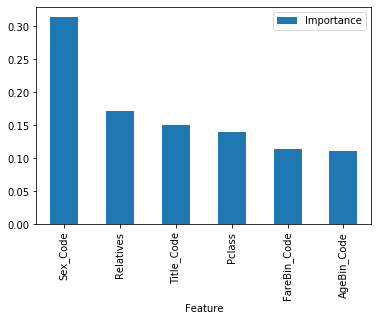

In [7]:
# measure accuracy and print
accuracy_pct = metrics.accuracy_score(val_y, y_preds) * 100
print(f"Accuracy: {accuracy_pct}%")

# measure the relative importance of each feature and plot 
stats = pd.DataFrame({
    "Feature": features,
    "Importance": model.feature_importances_
})
stats.sort_values(by='Importance', ascending=False, inplace=True)
stats.plot.bar(x='Feature', y='Importance');

# PREVIOUS ITERATIONS
# 66.816 - ['Pclass', 'SibSp', 'Parch', 'Fare'* ]
# 64.125 - ['Pclass', 'SibSp', 'Parch', 'Fare'*, 'Age'* ]
# 80.717 - ['Pclass'*, 'Relatives'*, 'IsAlone', 'Sex_Code'*, 'Embarked_Code', 'Title_Code'*, 'AgeBin_Code'*, 'FareBin_Code'* ]
# 82.062 - ['Pclass', 'Relatives', 'Sex_Code', 'Title_Code', 'AgeBin_Code', 'FareBin_Code' ] - 

In [8]:

# get predictions for competition data and prepare output file for submission
data_pred = pd.read_csv('https://raw.githubusercontent.com/straylight77/data-sci-learning/master/titanic/test.csv')

# do the same data processing that we did earlier

# fill in missing data
data_pred['Age'].fillna( data_pred['Age'].median(), inplace=True )
data_pred['Embarked'].fillna( data_pred['Embarked'].mode()[0], inplace=True )
data_pred['Fare'].fillna( data_pred['Fare'].median(), inplace=True )

# add new engineered features
data_pred['Relatives'] = data_pred['SibSp'] + data_pred['Parch']
data_pred['FareBin'] = pd.qcut(data_pred['Fare'], 4)
data_pred['AgeBin'] = pd.cut(data_pred['Age'].astype(int), 5)

# extract the passenger's title from their name (Mr, Miss, Dr, etc.)
data_pred['Title'] = data_pred['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]

# replace rare Titles (< stat_min) with 'Other'
stat_min = 10 
title_names = (data_pred['Title'].value_counts() < stat_min)
data_pred['Title'] = data_pred['Title'].apply(lambda x: 'Other' if title_names.loc[x] == True else x)

label = preprocessing.LabelEncoder()
data_pred['Sex_Code'] = label.fit_transform(data_pred['Sex'])
data_pred['Embarked_Code'] = label.fit_transform(data_pred['Embarked'])
data_pred['Title_Code'] = label.fit_transform(data_pred['Title'])
data_pred['AgeBin_Code'] = label.fit_transform(data_pred['AgeBin'])
data_pred['FareBin_Code'] = label.fit_transform(data_pred['FareBin'])

data_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 20 columns):
PassengerId      418 non-null int64
Pclass           418 non-null int64
Name             418 non-null object
Sex              418 non-null object
Age              418 non-null float64
SibSp            418 non-null int64
Parch            418 non-null int64
Ticket           418 non-null object
Fare             418 non-null float64
Cabin            91 non-null object
Embarked         418 non-null object
Relatives        418 non-null int64
FareBin          418 non-null category
AgeBin           418 non-null category
Title            418 non-null object
Sex_Code         418 non-null int64
Embarked_Code    418 non-null int64
Title_Code       418 non-null int64
AgeBin_Code      418 non-null int64
FareBin_Code     418 non-null int64
dtypes: category(2), float64(2), int64(10), object(6)
memory usage: 60.2+ KB


In [9]:
#####################################################################
# okay, now we can create a new model based on all training data
model = RandomForestClassifier(random_state=1)
model.fit(X, y)

X_predict = data_pred[features]
predictions = model.predict(X_predict)

output_df = pd.DataFrame({'PassengerId': data_pred.PassengerId, 'Survived': predictions})

output_df


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [10]:
output_df.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")


Your submission was successfully saved!
